# Imports

In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setup
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [4]:
# Load the dataset
file_path = "DA -Task 2..xlsx"
df = pd.read_excel(file_path)

In [5]:
# Drop fully empty columns
df.dropna(axis=1, how='all', inplace=True)

# Step 1: Initial Column-wise Summary

In [6]:
print("=== Basic Info ===")
print(df.info())
print("\n=== Missing Values ===")
print(df.isnull().sum())
print("\n=== Unique Values ===")
print(df.nunique())
print("\n=== Summary Stats ===")
print(df.describe())

=== Basic Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   VIN                            100 non-null    object        
 1   TRANSACTION_ID                 100 non-null    int64         
 2   CORRECTION_VERBATIM            100 non-null    object        
 3   CUSTOMER_VERBATIM              100 non-null    object        
 4   REPAIR_DATE                    100 non-null    datetime64[ns]
 5   CAUSAL_PART_NM                 95 non-null     object        
 6   GLOBAL_LABOR_CODE_DESCRIPTION  100 non-null    object        
 7   PLATFORM                       100 non-null    object        
 8   BODY_STYLE                     100 non-null    object        
 9   VPPC                           100 non-null    object        
 10  PLANT                          99 non-null     object        
 11  B

# Data Cleaning

In [7]:
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()
    df[col] = df[col].fillna(df[col].mode()[0])

# Handle numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

In [8]:
# -----------------------------
# Outlier Detection (IQR method)
# -----------------------------
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Keep original for comparison
df_before_outlier = df.copy()

In [9]:
# Remove outliers from key numeric columns
columns_to_check = ['KM', 'REPAIR_AGE', 'TOTALCOST']
df_cleaned = df.copy()
for col in columns_to_check:
    df_cleaned = remove_outliers(df_cleaned, col)

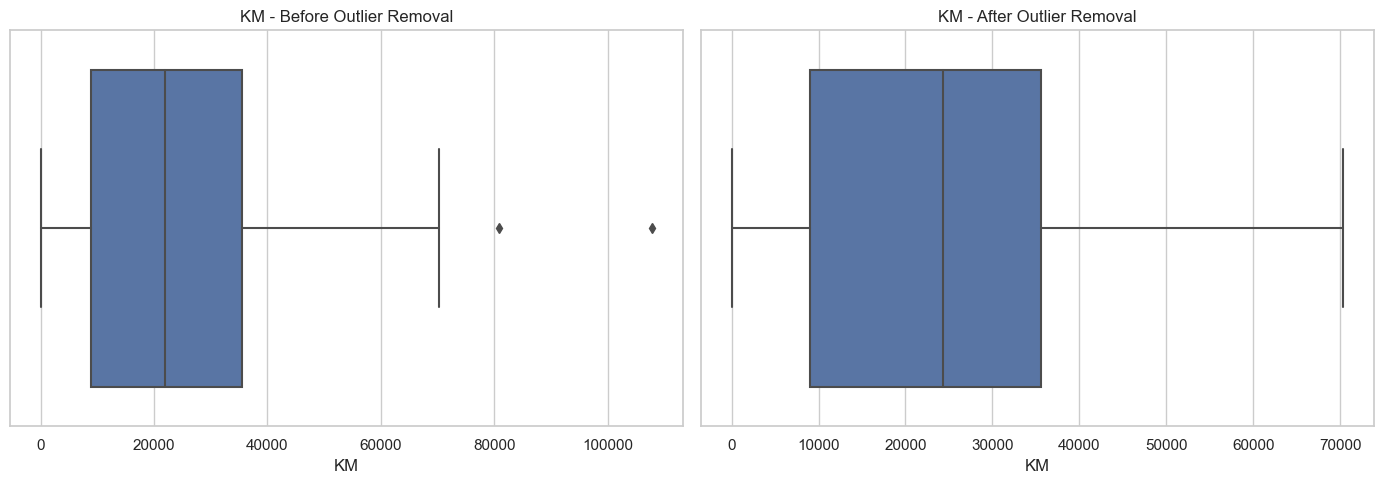

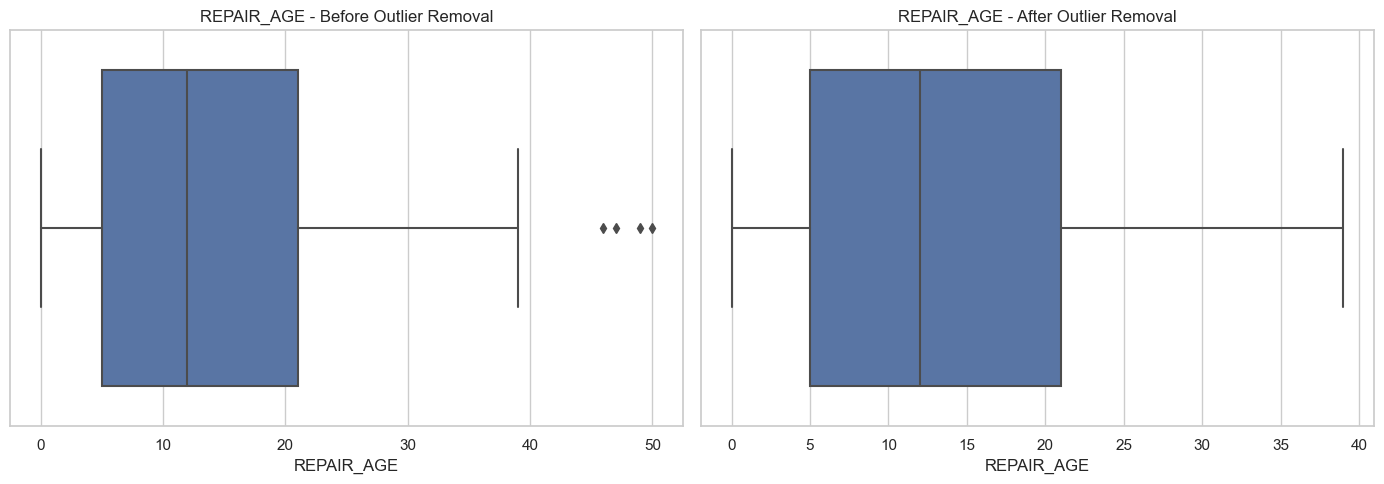

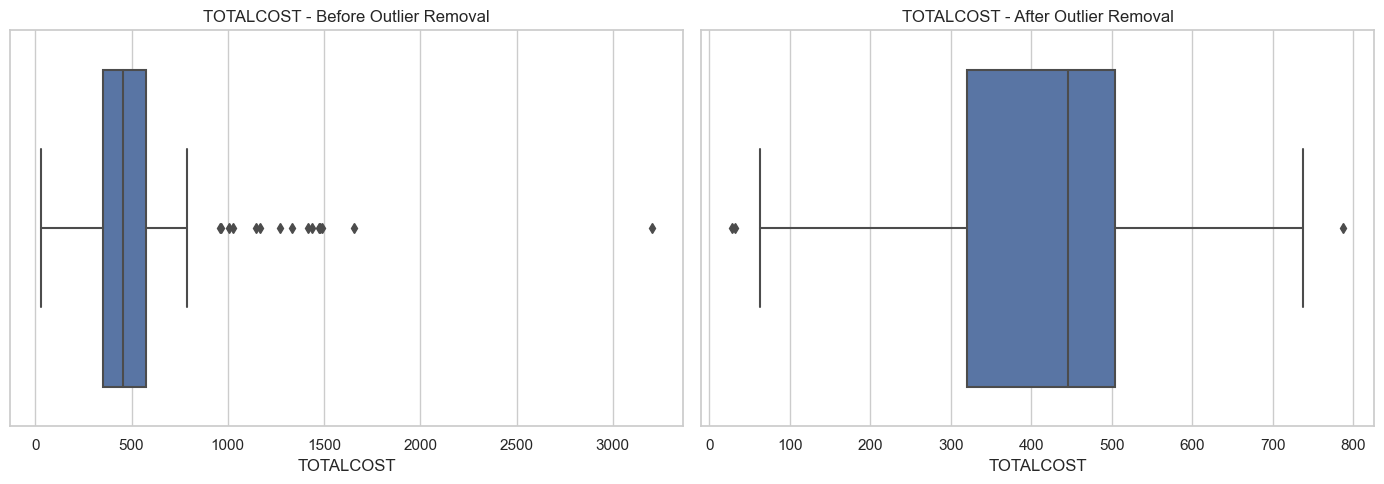

In [10]:
# -----------------------------
# Boxplot before and after outlier removal
# -----------------------------
for col in columns_to_check:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    sns.boxplot(data=df_before_outlier, x=col, ax=axes[0])
    axes[0].set_title(f"{col} - Before Outlier Removal")
    sns.boxplot(data=df_cleaned, x=col, ax=axes[1])
    axes[1].set_title(f"{col} - After Outlier Removal")
    plt.tight_layout()
    plt.show()

# Selecting critical columns

In [11]:
# Rename the corrected columns for ease of reference in EDA
df_selected = df_cleaned[['KM', 'TOTALCOST', 'STATE', 'VIN_MODL_DESGTR', 'CAUSAL_PART_NM', 'CORRECTION_VERBATIM']]
df_selected.columns = ['KM', 'TotalCost', 'State', 'Model', 'CausalPart', 'FailureDescription']

In [12]:
# Show basic info
basic_info = {
    "Shape": df_selected.shape,
    "Missing Values": df_selected.isnull().sum(),
    "Data Types": df_selected.dtypes,
    "Unique Values": df_selected.nunique()
}

In [13]:
basic_info

{'Shape': (79, 6),
 'Missing Values': KM                    0
 TotalCost             0
 State                 0
 Model                 0
 CausalPart            0
 FailureDescription    0
 dtype: int64,
 'Data Types': KM                      int64
 TotalCost             float64
 State                  object
 Model                  object
 CausalPart             object
 FailureDescription     object
 dtype: object,
 'Unique Values': KM                    79
 TotalCost             75
 State                 36
 Model                 38
 CausalPart            18
 FailureDescription    71
 dtype: int64}

In [14]:
# Summary statistics for numerical columns
summary_stats = df_selected.describe()
summary_stats

,KM,TotalCost
count,79.000000,79.000000
mean,24818.177215,411.710316
std,18179.233993,160.967378
min,3.000000,27.690000
25%,9006.000000,320.780000
50%,24304.000000,445.120000
75%,35534.500000,503.850000
max,70354.000000,787.930000


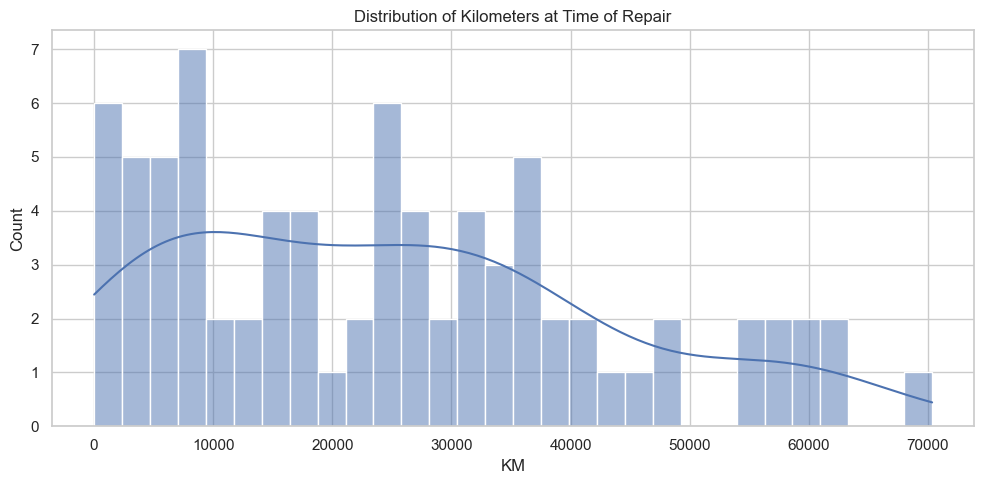

In [15]:
# Visualizations for selected columns

# 1. Histogram of KM
plt.figure()
sns.histplot(df_selected['KM'], kde=True, bins=30)
plt.title("Distribution of Kilometers at Time of Repair")
plt.xlabel("KM")
plt.tight_layout()
plt.show()

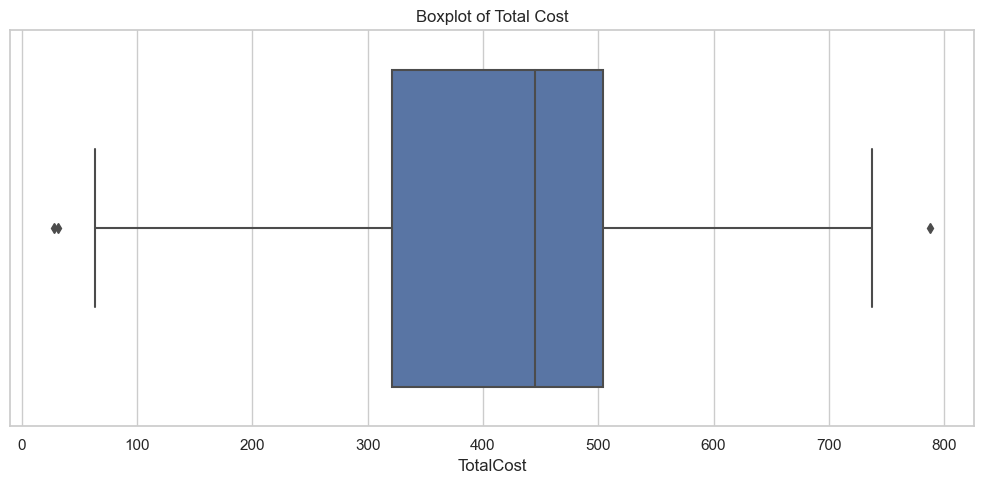

In [16]:
# 2. Boxplot of Total Cost
plt.figure()
sns.boxplot(x=df_selected['TotalCost'])
plt.title("Boxplot of Total Cost")
plt.tight_layout()
plt.show()

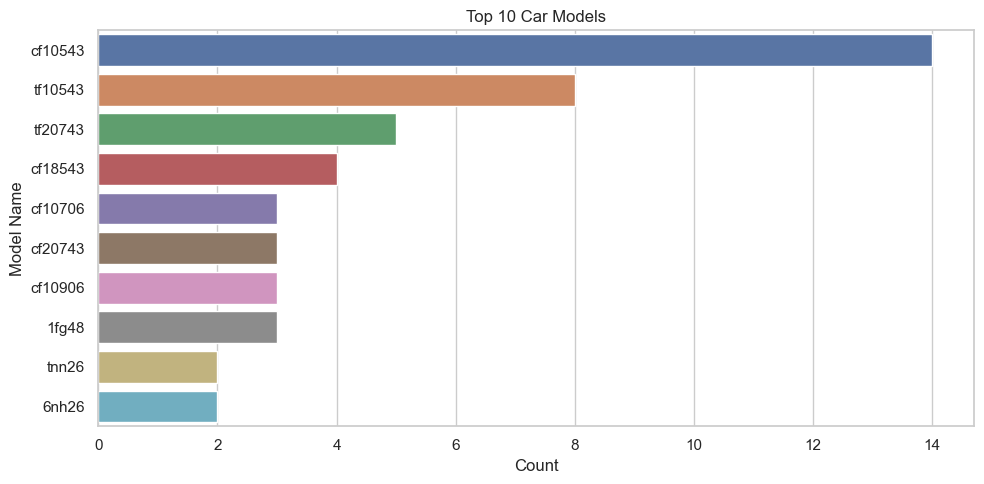

In [17]:
# 3. Count plot of top 10 models
plt.figure()
top_models = df_selected['Model'].value_counts().head(10)
sns.barplot(x=top_models.values, y=top_models.index)
plt.title("Top 10 Car Models")
plt.xlabel("Count")
plt.ylabel("Model Name")
plt.tight_layout()
plt.show()


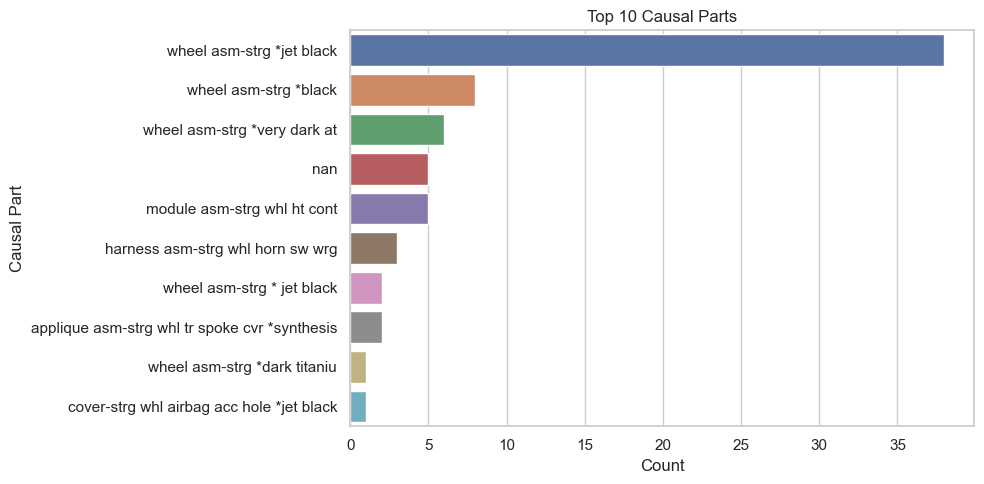

In [18]:
# 4. Count plot of top 10 causal parts
plt.figure()
top_parts = df_selected['CausalPart'].value_counts().head(10)
sns.barplot(x=top_parts.values, y=top_parts.index)
plt.title("Top 10 Causal Parts")
plt.xlabel("Count")
plt.ylabel("Causal Part")
plt.tight_layout()
plt.show()

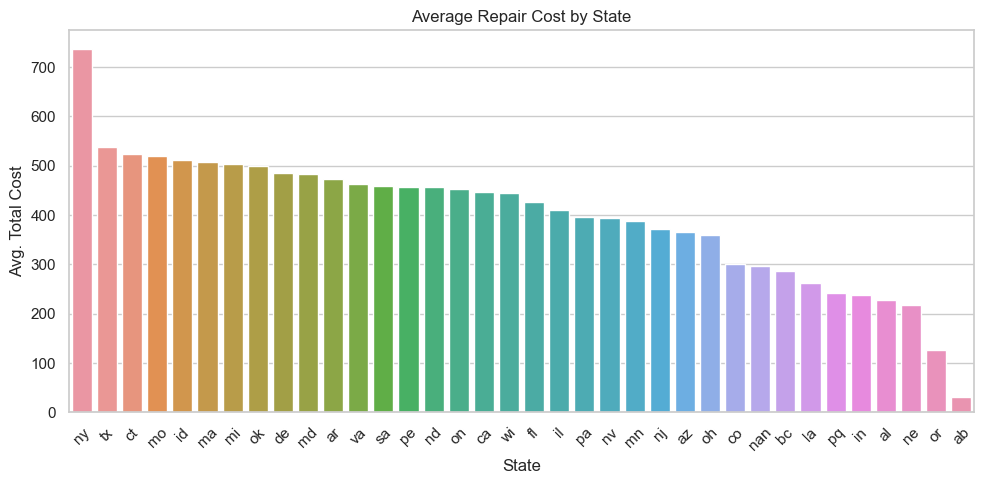

In [19]:
# 5. Average total cost by state
plt.figure()
avg_cost_state = df_selected.groupby("State")["TotalCost"].mean().sort_values(ascending=False)
sns.barplot(x=avg_cost_state.index, y=avg_cost_state.values)
plt.title("Average Repair Cost by State")
plt.xlabel("State")
plt.ylabel("Avg. Total Cost")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

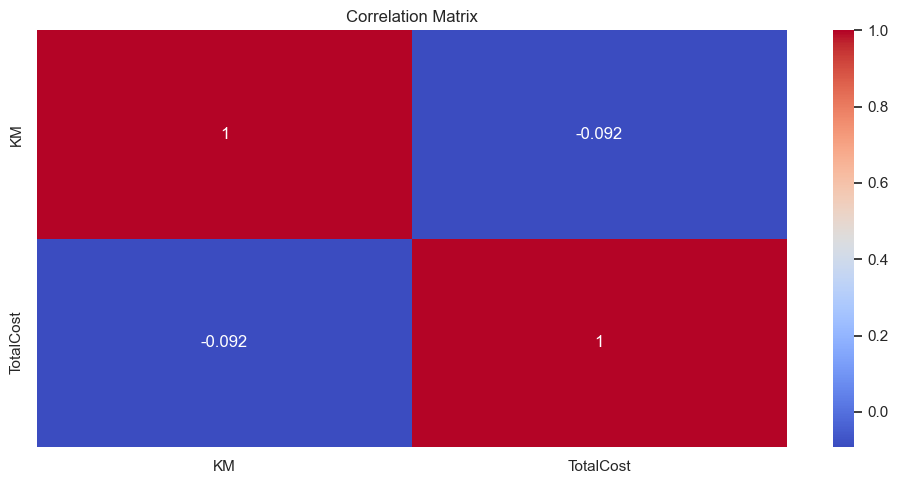

In [20]:
# 6. Correlation matrix for numerical columns
plt.figure()
corr = df_selected[['KM', 'TotalCost']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

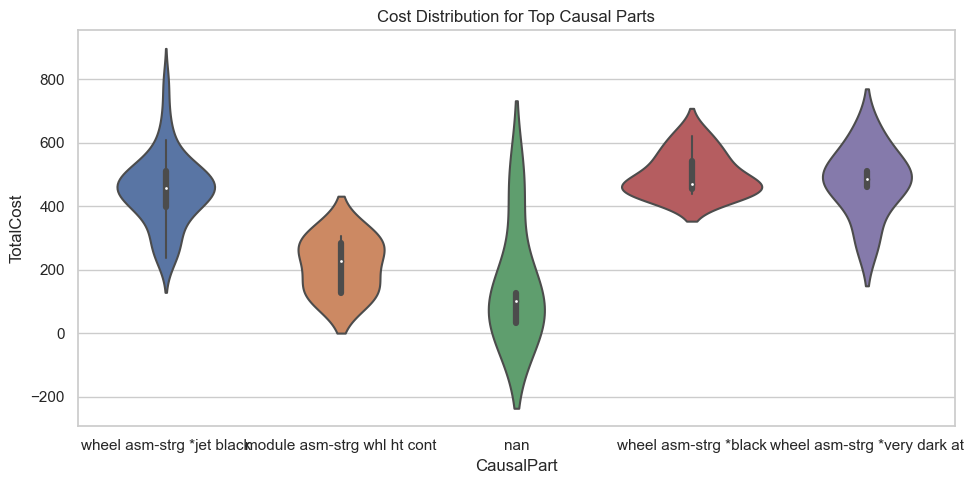

In [21]:
# 7. Violin plot of Total Cost by top causal parts
plt.figure()
violin_parts = df_selected['CausalPart'].value_counts().head(5).index
sns.violinplot(data=df_selected[df_selected['CausalPart'].isin(violin_parts)],
               x='CausalPart', y='TotalCost')
plt.title("Cost Distribution for Top Causal Parts")
plt.tight_layout()
plt.show()

In [22]:
df_selected['FailureDescription']

0                      replaced steering wheel now okay
1     checked - found dtc's u0229 - u1530 set in bcm...
3                            steering wheel replacement
5        remove and replace steering wheel wire harness
7                               replaced steering wheel
                            ...                        
93    inspected steering wheel and found leather und...
94                                    replaced applique
97              replace steering wheel pra 496735300000
98    removed steering wheel and disassembled and fo...
99    r&r steering wheel for bad stitching. -returne...
Name: FailureDescription, Length: 79, dtype: object

 # Step 4: Generate Tags from Free Text

In [32]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_tags_spacy(text):
    doc = nlp(text.lower())
    tags = set()
    for chunk in doc.noun_chunks:
        if len(chunk.text.strip()) > 2:
            tags.add(chunk.text.strip())
    return list(tags)

df_selected.loc[:, 'Tags'] = df_selected['FailureDescription'].apply(extract_tags_spacy)

In [34]:
df_selected['Tags'][:8]

0                             [replaced steering wheel]
1     [pip5883j, faulty heated s-w module, s-w modul...
3                                   [wheel replacement]
5                         [steering wheel wire harness]
7                             [replaced steering wheel]
8     [technician, properly adjusted trim, the custo...
10    [wheel molding, that, connected battery, insta...
11                  [pra, tech replaced steering wheel]
Name: Tags, dtype: object

In [35]:
df_selected.head(5)

,KM,TotalCost,State,Model,CausalPart,FailureDescription,Tags
0,8872,370.03,mi,cf10543,wheel asm-strg *jet black,replaced steering wheel now okay,[replaced steering wheel]
1,16346,307.32,mn,tf10543,module asm-strg whl ht cont,checked - found dtc's u0229 - u1530 set in bcm...,"[pip5883j, faulty heated s-w module, s-w modul..."
3,15500,445.28,wi,cf10543,wheel asm-strg *jet black,steering wheel replacement,[wheel replacement]
5,14,216.75,ne,tf10543,harness asm-strg whl horn sw wrg,remove and replace steering wheel wire harness,[steering wheel wire harness]
7,4065,427.08,oh,cf10543,wheel asm-strg *jet black,replaced steering wheel,[replaced steering wheel]


In [36]:
df_selected.to_csv("cleaned_tagged_data.csv", index=False)
